<a href="https://colab.research.google.com/github/ssffssff/vlsi/blob/main/digital-fulladder-openlane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital Fulladder with OpenLane

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run a simple digital inverter design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

In [1]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version}
!python -m pip install gdstk gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


Empty environment created at prefix: /content/conda-env

Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - openlane=*
   - open_pdks.sky130a=*


  Package                                                Version  Build                 Channel        Size
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────────────────

  + open_pdks.sky130a                         1.0.456_0_g2a38e86  20231104_052339       litex-hub       1GB
  + _libgcc_mutex                                            0.1  main                  main            3kB
  + libstdcxx-ng                                          11.2.0  h1234567_1            main            6MB
  + ld_impl_linux-64                                        2.38  h1181459_1            main          749kB
  + libgcc-devel_linux-64      

## Write verilog

In [42]:
%%writefile fulladder.v
module fulladder(
  input wire a,
  input wire b,
  input wire cin,
  output wire sum,
  output wire carry
);
  assign sum = a ^ b ^ cin;
  assign carry = (a&b) | (b&cin) | (a&cin);
endmodule

Overwriting fulladder.v


## Write configuration

[Documentation](https://openlane.readthedocs.io/en/latest/reference/configuration.html)

In [45]:
!python3 -m venv env
!source env/bin/activate
!python -m pip install -r requirements-dev.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.1/325.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [43]:
%%writefile config.json
{
    "DESIGN_NAME": "fulladder",
    "VERILOG_FILES": "dir::fulladder.v",
    "RUN_CTS": false,
    "CLOCK_PORT": null,
    "PL_RANDOM_GLB_PLACEMENT": true,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 40 60",
    "PL_TARGET_DENSITY": 0.75,
    "FP_PDN_AUTO_ADJUST": false,
    "FP_PDN_VPITCH": 25,
    "FP_PDN_HPITCH": 25,
    "FP_PDN_VOFFSET": 5,
    "FP_PDN_HOFFSET": 5,
    "DIODE_INSERTION_STRATEGY": 3
}

Overwriting config.json


## Run OpenLane Flow

[OpenLane](https://openlane.readthedocs.io/en/latest/) is an automated [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) to [GDSII](https://en.wikipedia.org/wiki/GDSII) flow based on several components including [OpenROAD](https://theopenroadproject.org/), [Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/) and custom methodology scripts for design exploration and optimization targeting [open source PDKs](https://github.com/google/open-source-pdks).

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

In [44]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2023.11.03_0_gf4f8dad8-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[WARNING]: DIODE_INSERTION_STRATEGY is now deprecated; use GRT_REPAIR_ANTENNAS, DIODE_ON_PORTS and RUN_HEURISTIC_DIODE_INSERTION instead.
[INFO]: DIODE_INSERTION_STRATEGY set to 3. Setting GRT_REPAIR_ANTENNAS to 1
[INFO]: Run Directory: /content/runs/RUN_2023.11.08_22.56.07
[INFO]: Saving runtime environment...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[WARNING]: PNR_SDC_FILE is not set. It is recommended to write a custom SDC file 

In [17]:
!pip install libparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.6 MB/s eta 0:00:00


## Display layout

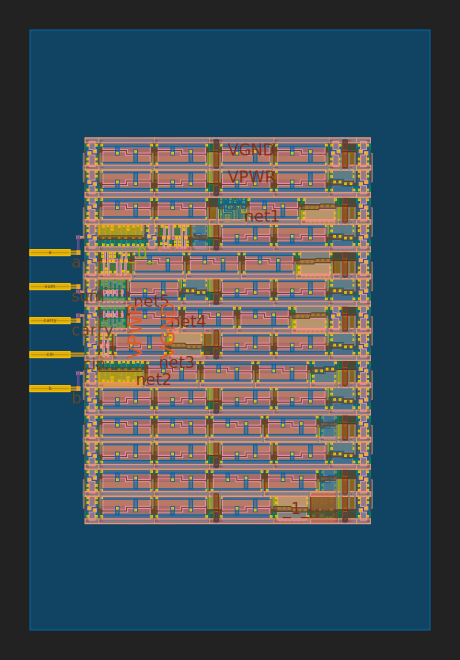

In [45]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('fulladder.svg')
IPython.display.SVG('fulladder.svg')

## Metrics

[Documentation](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html)


In [46]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,fulladder
config,RUN_2023.11.08_22.56.07
flow_status,flow completed
total_runtime,0h0m58s0ms
routed_runtime,0h0m34s0ms
(Cell/mm^2)/Core_Util,7500.0
DIEAREA_mm^2,0.0024
CellPer_mm^2,3750.0
OpenDP_Util,-1
